**Houses Pricing Prediction**

In [508]:
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

**Data Preprocessing**
*  First, we need to check if the data has any missing values so that the output for all the features is zero so that mean no missing values in the dataset.
*  Visualized the data to have an insight about the features and their distributions.
*  Applied Label Encoding for every non-numerical feature such as airconditioning, mainroad, and basement.
*  Normalized the data for better and faster training using MinMaxScaler.

In [509]:
df = pd.read_csv('Housing-1.csv')

In [510]:
#Check for missing values
df.isna().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


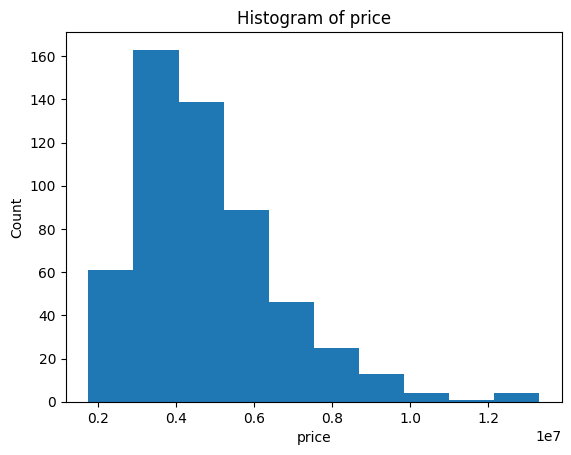

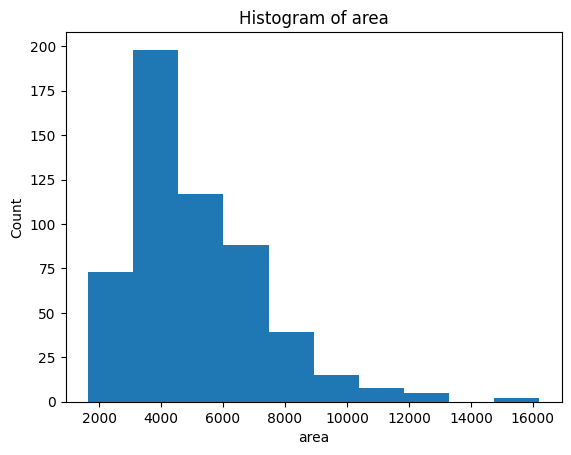

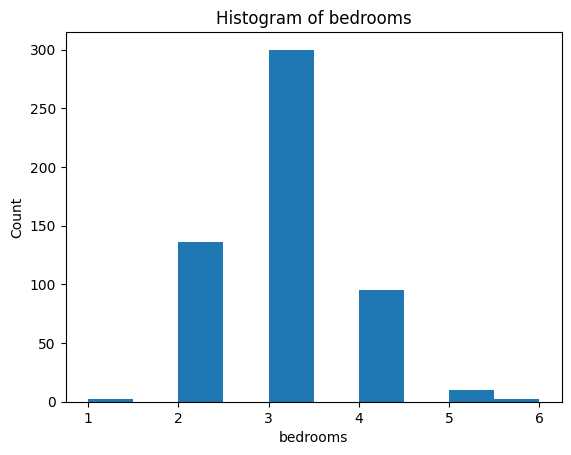

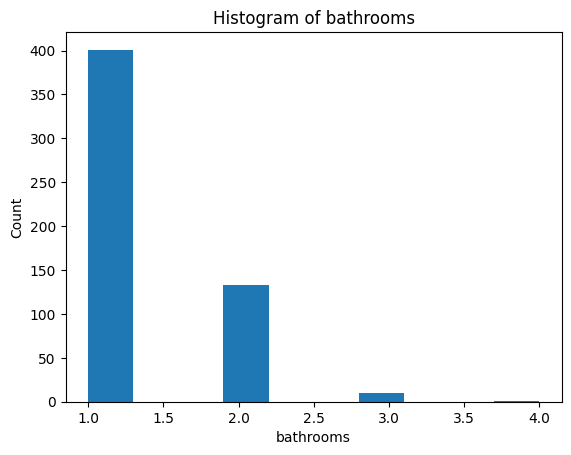

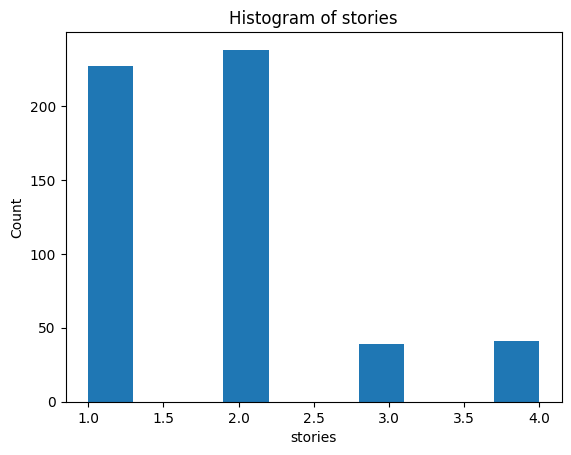

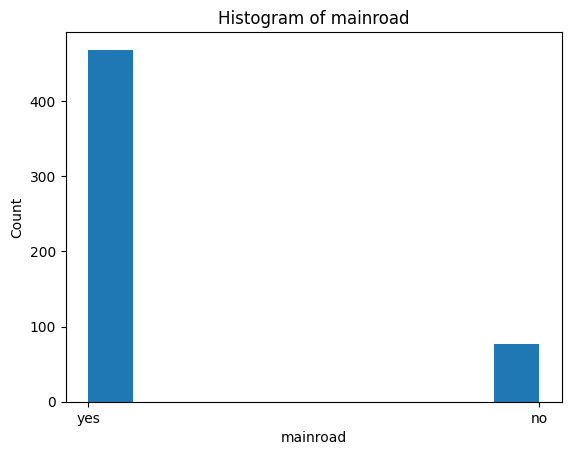

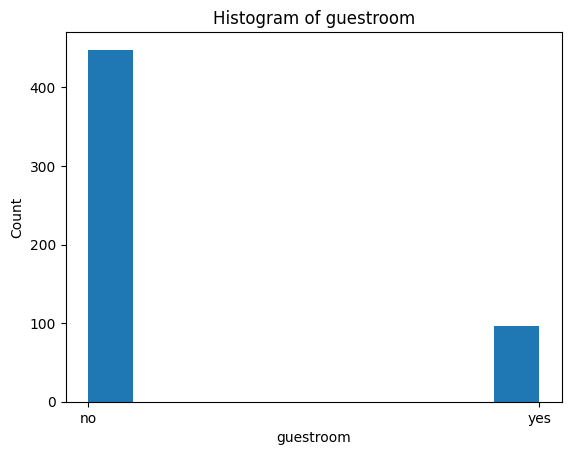

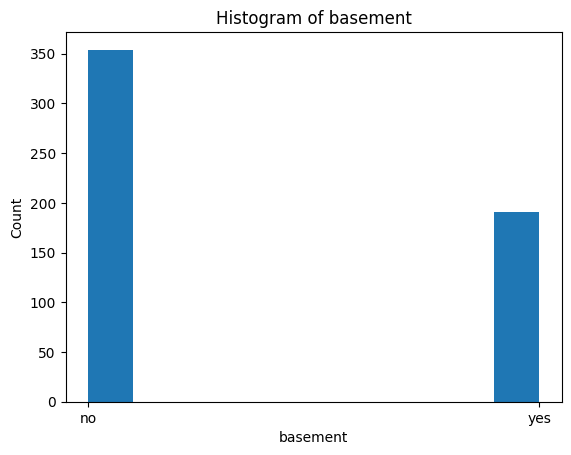

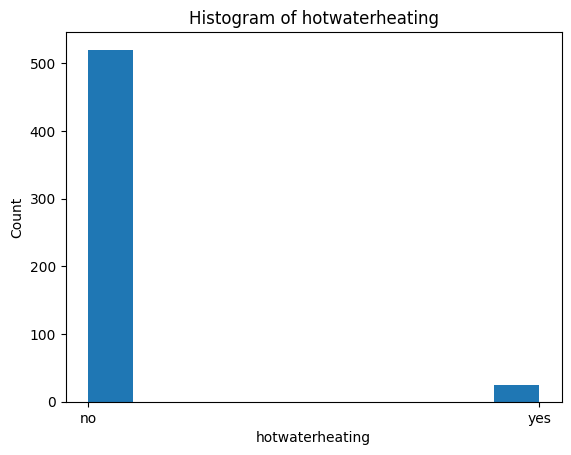

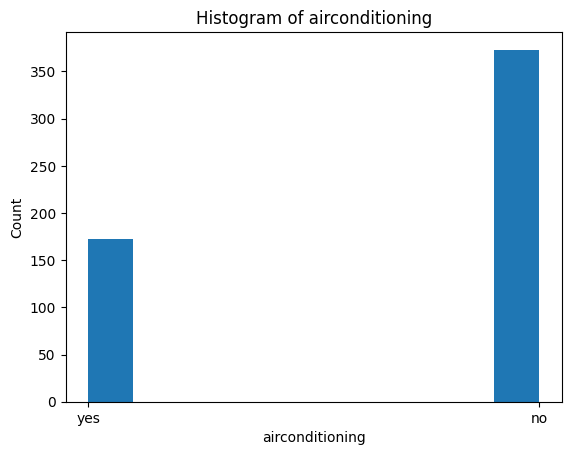

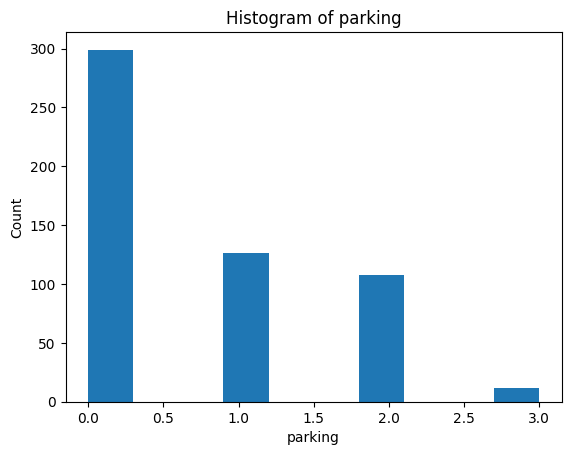

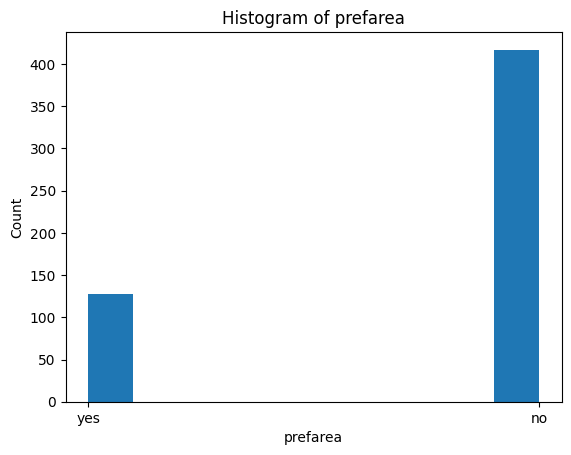

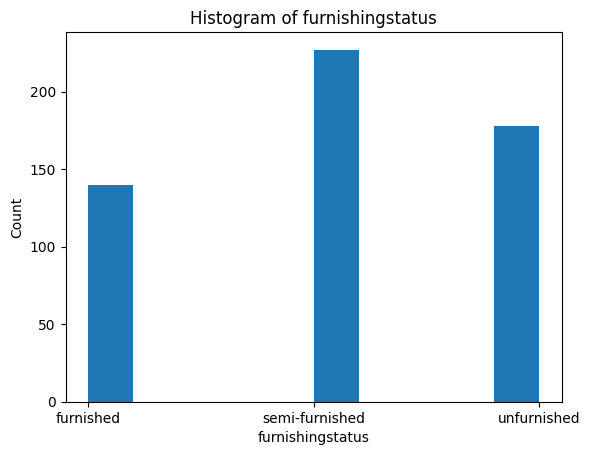

Number of features = 12


In [511]:
#Visulaizing Dataset
i = 0
for feature in df.columns:
    plt.hist(df[feature])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Histogram of {feature}')
    plt.show()
    i = i+1
print(f"Number of features = {i-1}")

In [512]:
x_df = df.drop(['furnishingstatus','price'], axis=1)
y_df = df['price']
print(x_df.head)

<bound method NDFrame.head of      area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0    7420         4          2        3      yes        no       no   
1    8960         4          4        4      yes        no       no   
2    9960         3          2        2      yes        no      yes   
3    7500         4          2        2      yes        no      yes   
4    7420         4          1        2      yes       yes      yes   
..    ...       ...        ...      ...      ...       ...      ...   
540  3000         2          1        1      yes        no      yes   
541  2400         3          1        1       no        no       no   
542  3620         2          1        1      yes        no       no   
543  2910         3          1        1       no        no       no   
544  3850         3          1        2      yes        no       no   

    hotwaterheating airconditioning  parking prefarea  
0                no             yes        2      yes  
1    

In [513]:
#data preprocessing
x_df['mainroad'] = x_df['mainroad'].map({'yes':1, 'no':0})
x_df['airconditioning'] = x_df['airconditioning'].map({'yes':1, 'no':0})
x_df['prefarea'] = x_df['prefarea'].map({'yes':1, 'no':0})
x_df['hotwaterheating'] = x_df['hotwaterheating'].map({'yes':1, 'no':0})

x_df['guestroom'] = x_df['guestroom'].map({'yes':1, 'no':0})
x_df['basement'] = x_df['basement'].map({'yes':1, 'no':0})
print(x_df.head)

<bound method NDFrame.head of      area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0    7420         4          2        3         1          0         0   
1    8960         4          4        4         1          0         0   
2    9960         3          2        2         1          0         1   
3    7500         4          2        2         1          0         1   
4    7420         4          1        2         1          1         1   
..    ...       ...        ...      ...       ...        ...       ...   
540  3000         2          1        1         1          0         1   
541  2400         3          1        1         0          0         0   
542  3620         2          1        1         1          0         0   
543  2910         3          1        1         0          0         0   
544  3850         3          1        2         1          0         0   

     hotwaterheating  airconditioning  parking  prefarea  
0                  0  

In [514]:
#Normalization
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler() #x_scaled = (x - x_min) / (x_max - x_min)
x_df = scaler.fit_transform(x_df)
print(x_df)

[[0.39656357 0.6        0.33333333 ... 1.         0.66666667 1.        ]
 [0.5024055  0.6        1.         ... 1.         1.         0.        ]
 [0.57113402 0.4        0.33333333 ... 0.         0.66666667 1.        ]
 ...
 [0.13539519 0.2        0.         ... 0.         0.         0.        ]
 [0.08659794 0.4        0.         ... 0.         0.         0.        ]
 [0.15120275 0.4        0.         ... 0.         0.         0.        ]]


In [517]:
#Splitting Dataset to train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [518]:
#Convert numpy arrays to tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
x_val = torch.from_numpy(x_val).float()

y_train = torch.from_numpy(y_train.values).float().reshape(-1,1)
y_test = torch.from_numpy(y_test.values).float().reshape(-1,1)
y_val = torch.from_numpy(y_val.values).float().reshape(-1,1)

In [519]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(type(x_train))
print(y_train.shape)

torch.Size([436, 11])
torch.Size([54, 11])
torch.Size([55, 11])
<class 'torch.Tensor'>
torch.Size([436, 1])


**Model Training and Evaluation Loops**
*   Trained with batched for faster training and noise reduction.


In [515]:
#Training loop
def training(epochs, model, optimizer, loss_fn, x_train, y_train, batch_size):
    for epoch in range(epochs):
      model.train()
      samples = len(x_train)
      for batch in range(samples//batch_size):
                start = batch * batch_size
                end = start + batch_size

                y_pred_train = model(x_train[start:end]) #forward pass
                loss = loss_fn(y_pred_train, y_train[start:end]) #calculate loss
                train_loss = loss.item()
                #backward pass
                optimizer.zero_grad() #reset gradients
                loss.backward() #calculate gradients
                optimizer.step() #update weights

      #backward pass
      optimizer.zero_grad() #reset gradients

      print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}")


In [516]:
#Test loop
def testing(model,x_test):
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)

  return y_pred

**Model Creation**
*   This model is made of an input layer which includes 11 features, 2 hidden layers, and an output layer.
*   The loss function is Mean Absolute Error and the optimizer is adam with a learning rate of 0.01

In [520]:
#Model Arcitecture
model = nn.Sequential(
    nn.Linear(11, 64), # Input layer 11 neurons and hidden layer 64 neurons
    nn.ReLU(), # Activation function
    nn.Linear(64, 16), # Second Hidden Layer 32 neurons
    nn.ReLU(), # Activation function
    nn.Linear(16, 1) # Output layer
)

summary(model, input_size=(1,11))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             768
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 16]           1,040
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [521]:
#Setting an optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

**Model Training**

In [522]:
#train and show training and
training(2000, model, optimizer, loss_fn, x_train,y_train, 32)

Epoch 1/2000 - Training Loss: 4486775.0000
Epoch 2/2000 - Training Loss: 4486735.0000
Epoch 3/2000 - Training Loss: 4486593.0000
Epoch 4/2000 - Training Loss: 4486230.5000
Epoch 5/2000 - Training Loss: 4485486.0000
Epoch 6/2000 - Training Loss: 4484161.5000
Epoch 7/2000 - Training Loss: 4482033.5000
Epoch 8/2000 - Training Loss: 4478863.5000
Epoch 9/2000 - Training Loss: 4474402.0000
Epoch 10/2000 - Training Loss: 4468395.5000
Epoch 11/2000 - Training Loss: 4460586.0000
Epoch 12/2000 - Training Loss: 4450720.0000
Epoch 13/2000 - Training Loss: 4438540.0000
Epoch 14/2000 - Training Loss: 4423796.0000
Epoch 15/2000 - Training Loss: 4406237.5000
Epoch 16/2000 - Training Loss: 4385619.0000
Epoch 17/2000 - Training Loss: 4361698.0000
Epoch 18/2000 - Training Loss: 4334235.5000
Epoch 19/2000 - Training Loss: 4302996.0000
Epoch 20/2000 - Training Loss: 4267748.5000
Epoch 21/2000 - Training Loss: 4228265.0000
Epoch 22/2000 - Training Loss: 4184321.0000
Epoch 23/2000 - Training Loss: 4135697.50

**Model Testing**

In [525]:
y_pred = testing(model,x_test)


In [526]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

R2 score: 0.6098059463691567


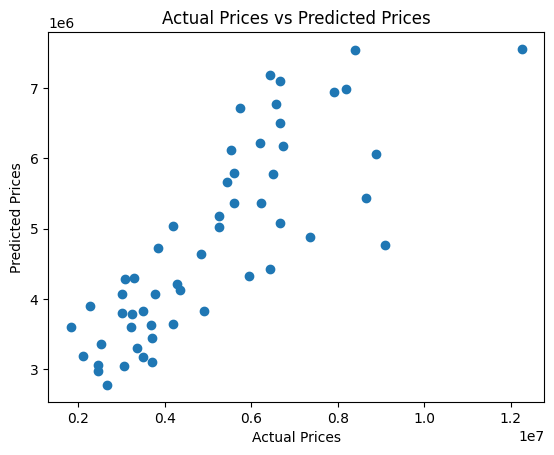

In [527]:
#plot model prediction
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual Prices vs Predicted Prices")
plt.show()